## Importing needed libraries

In [21]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline  
import glob
import random
from skimage.color import rgb2gray
from skimage.transform import rotate
from utilities import * 

## Functions needed

In [22]:
'''
Extract The start and end of each sequence of successive true values in the array.

params:
------
arr          np.array  boolean array containing false and true values

return:
-------
lines_start  np.array  array containing the start index of each sequence of true values.
lines_end    np.array  array containing the end index of each sequence of true values.

example:
-------

arr = np.array([True True False True True True False True False])
lines_start, lines_end = extract_successive_trues(arr)

>> lines_start
array([0 3 7])

>> lines_end
array([2 6 8])

'''
def extract_successive_trues(horiz_proj):
    processing_line = False
    lines_start = []
    lines_end = []

    for i in range(len(horiz_proj)):
        if(processing_line == True):
            if(horiz_proj[i] == False):
                lines_end.append(i)
                processing_line = False
        else:
            if(horiz_proj[i] == True):
                processing_line = True
                lines_start.append(i)
                
    # if the last element in arr was true
    if (len(lines_end) == len(lines_start) - 1):
        # Set the end of the last line as the last index of the array
        lines_end.append(len(horiz_proj))
        
    return lines_start, lines_end

In [23]:
'''
Extract lines from a handwritten image.

params:
-------
img                   np.arrray()   Image to extract lines from.
margin_top            float         How many pixels above the extracted line to consider.
margin_bottom         float         How many pixels below the extracted line to consider.
avg_thickness_perc    float         The percentage of the average thickness below which to discard a line.
verbose               boolean       If true show a visualization of the lines extracted. By default: False.

returns:
-------
lines                 list          List of images, each image holds a line extracted from the original image. Each image is an np.array.
'''
def extract_lines(img, margin_top=30, margin_bottom=15, avg_thickness_perc = 0.5, verbose=False):
    
    # Sum across the horizontal axis i.e across the text lines
    horiz_proj = np.sum(img, axis=1)
    
    # Calculating the threshold between having text (a line) or having white spacing between lines
    avg = np.average(horiz_proj)
    margin = (np.max(horiz_proj)-avg)/3
    thres = avg + margin
    
    if (verbose):
        # Rotate image by 90 degrees
        img_90 = rotate(img, 90, resize=True)
        plt.imshow(img_90, cmap='gray')

        # Plot the lines' summation values
        plt.plot(range(0,len(horiz_proj)),horiz_proj) 

        plt.axhline(y=thres, color='r', linestyle='-')
        plt.show()
    
    # Extract Lines start index and end index
    lines_start, lines_end = extract_successive_trues(horiz_proj < thres)
    
    lines = []
    lines_thickness = []

    # Discard noisy lines - lines with thickness smaller than 10 pixels
    for i in range(len(lines_start)):
        line_thickness = lines_end[i] - lines_start[i]
        if (line_thickness > 10):
            lines_thickness.append(line_thickness)  

    # Estimate the average thickness of filtered lines (for Lines > 10 pixels)
    lines_thickness = np.array([lines_thickness])
    avg_thickness = np.average(lines_thickness)
    
    lines_thickness = []
    # Extract the lines from the image
    for i in range(len(lines_start)):
        # Add margines to the lines starting and ending indices
        line_top = lines_start[i] - margin_top
        line_bottom = lines_end[i] + margin_bottom

        line_thickness = lines_end[i] - lines_start[i]
        # Discard noisy lines - lines with thickness smaller than 0.5 of the average thicknesses (default)
        if (line_thickness > avg_thickness_perc*avg_thickness):
            lines_thickness.append(line_thickness)
            lines.append(img[line_top:line_bottom, :])
            if (verbose):
                plt.imshow(img[line_top:line_bottom, :])
                plt.show()

    if (verbose):
        print("lines' thickness array: ", lines_thickness[0])
        print('avg thickness of this paper: ', avg_thickness)
        print('discard lines thiner than: ', avg_thickness*avg_thickness_perc)
        print("final lines' thickness array: ", lines_thickness)

    return lines

In [24]:
'''
Removing white space margins from the left and right endings of a handwritten line.

params:
-------
lines               list     List of images, each image is a np.array representing a handwritten line.

noise_margin_perc   float    Percentage of the degree of white (1.0) to consider as a margin. 
                             Margin is not considered to be 100% white in order to account for errors in the binary image due to illumination and camera effects.

verbose             boolean  If true show a visualization of the cropped lines. By default: False.

return:
------
cropped_lines       list     List of images, each image is a line cropped from of its left and right white margins.

'''
def cut_white_margins(lines, noise_margin_perc = 0.95, verbose=False):
    cropped_lines = []
    
    for i in range(len(lines)):
        
        # First remove 10 pixels from right and left
        # These pixels are the edges of the img and are usually containing noisy black ink? 
        
        # Project the line vertically
        vert_proj = np.sum(lines[i], axis=0)
        # Get line thickness in pixels
        line_thickness = lines[i].shape[0]

        # Cut the start and end of the projection array
        # Cut from the start going to right till a threshold is violated
        # Cut from the end going to the left till a threshold is violated
        # Threshold is set to account for lighting effects in the binary thresholding.
#         print('vert_proj', vert_proj)
#         print('thresh', line_thickness*noise_margin_perc)
        vert_proj = vert_proj <= line_thickness*noise_margin_perc

        # Finding the end of the line's left white-margin
        end_of_left_margin = 0
        while(not vert_proj[end_of_left_margin]):
            end_of_left_margin += 1

        # Finding the start of the line's right white-margin
        start_of_right_margin = len(vert_proj) - 1
        while(not vert_proj[start_of_right_margin]):
            start_of_right_margin -= 1

        # Remove left and right White-margins from the line
        cropped_line = lines[i][:, end_of_left_margin:start_of_right_margin]
        cropped_lines.append(cropped_line)
        
        # Visualize the line with the projection result
        if (verbose):
            plt.imshow(lines[i])
            plt.axvline(x=start_of_right_margin, color='b', linestyle='-')
            plt.axvline(x=end_of_left_margin, color='b', linestyle='-')
            plt.show()
            
    return cropped_lines

## Read Sample of images

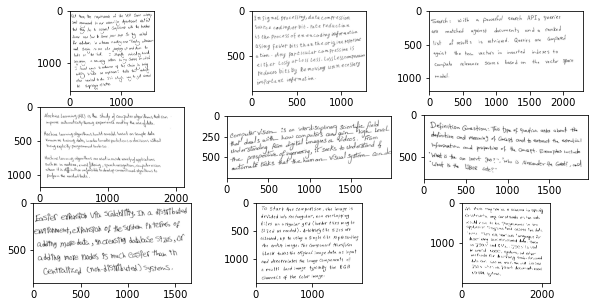

In [25]:
# Read the test images
imgs = read_imgs('../Data/space_testing')

# Preview 9 samples
draw_grid(figsize=(10,5), rows=3, cols=3, imgs=imgs[:9])

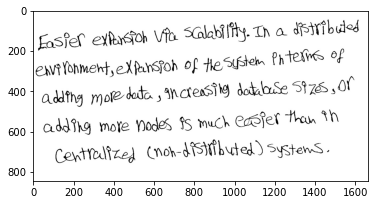

In [26]:
# Choosing a random image
rand_indx = random.randint(0,len(imgs))
img = imgs[rand_indx]
plt.imshow(img)
plt.show()
# Trivial Thresholding the image to only 0 and 255
img = rgb2gray(img)
img_black_loc = img <= 0.5
img_white_loc = img > 0.5
img[img_black_loc] = 0
img[img_white_loc] = 1

## Extract Lines and remove their left and right white-margins

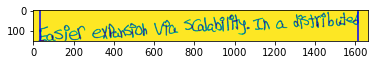

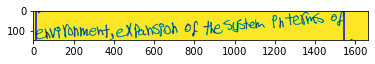

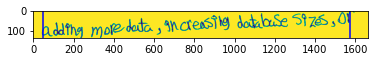

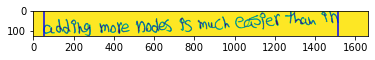

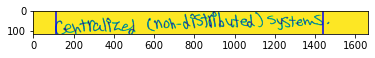

In [27]:
lines = extract_lines(img=img, verbose=False)
lines = cut_white_margins(lines=lines, noise_margin_perc=0.9, verbose=True)